# eXplainable Artificial Intelligence (XAI)

### Resumo

Aplicação de algumas técnicas de XAI de diferentes tipos/abordagens na classificação binária de doenças cardíacas (heart disase dataset, disponível em https://archive.ics.uci.edu/ml/datasets/heart+disease).

Neste notebooks são utilizados as seguintes técnicas: 
- **Feature Importance - ELI5**
- **LIME**
- **Anchor**
- **SHAP**
- **Partial Dependence Plot (PDP)**
- **Accumulated Local Effects Plot (ALE)** 
- **Counterfactual**

Na primeira etapa é realizado um tratamento básico no dataset e depois é realizado o treinamento dos modelos de ML. <br/>
Em seguida é a parte de XAI.

In [1]:
seed = 42

## Preparação dos dados e Modelagem
#### Resumo do que foi realizado:
- Carrega os dados
- Transforma a variável alvo em binária (ausência ou presença de doença)
- Tratamento de dados faltantes
- Encoding de variáveis categóricas com One Hot
- Separação dos dados
- Normalização
- Treinamento de dois modelos: Random Forest (sklearn) e Neural Network (Keras)

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix

import matplotlib.pyplot as plt

### Load Data

In [3]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

**Attribute Information (abbreviature - description):**
- age - **age**
- sex - **sex (1 = male; 0 = female)**
- cp - **chest pain type (4 values: 1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)**
- trestbps - **resting blood pressure**
- chol - **serum cholestoral in mg/dl**
- fbs - **fasting blood sugar > 120 mg/dl (1 = true; 0 = false)**
- restecg - **resting electrocardiographic results (values 0,1,2)**
- thalach - **maximum heart rate achieved**
- exang - **exercise induced angina (1 = yes; 0 = no)**
- oldpeak = **ST depression induced by exercise relative to rest**
- slope - **the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)**
- ca - **number of major vessels (0-3) colored by flourosopy**
- thal: **3 = normal; 6 = fixed defect; 7 = reversable defect**

In [129]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', names=columns, na_values='?')

In [5]:
print(data.shape)
data.head()

(303, 14)


age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0

### Ajustando alvo para uma Classificação Binária
A variável alvo (target) contém 4 valores, entretanto os estudos com essa base de dados estão concentrados em simplesmente distinguir a existência de doença (1,2 ou 3) da ausência (0).

#### Distribuição original

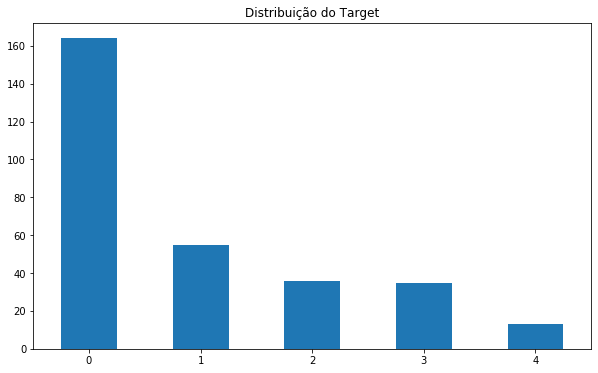

In [6]:
data['target'].value_counts().plot(kind='bar', title='Distribuição do Target', figsize=(10, 6), rot=0)
plt.show()

#### Conversão alvo

In [7]:
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

#### Distribuição do alvo ajustado

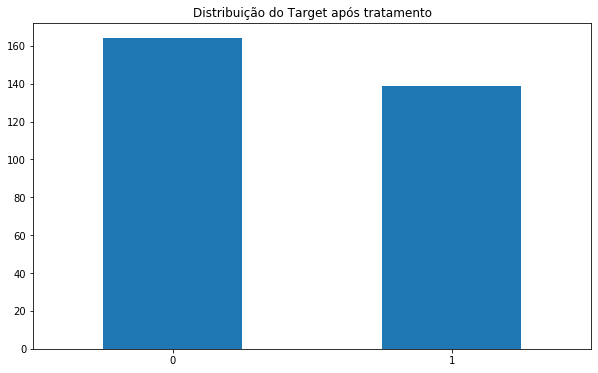

In [8]:
data['target'].value_counts().plot(kind='bar', title='Distribuição do Target após tratamento', figsize=(10, 6), rot=0)

In [9]:
data['target'].value_counts(normalize=True)

0    0.541254
1    0.458746
Name: target, dtype: float64

### Tratamento de Missing values

In [10]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

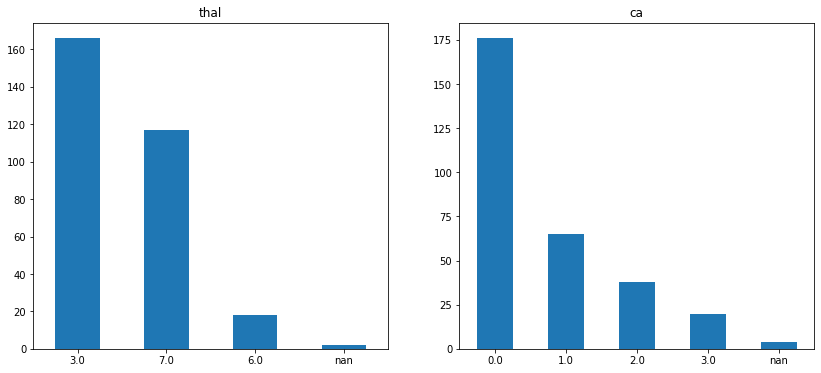

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
data['thal'].value_counts(dropna=False).plot(kind='bar', rot=0, ax=axs[0], title='thal')
data['ca'].value_counts(dropna=False).plot(kind='bar', rot=0, ax=axs[1], title='ca')

In [12]:
inputer_thal = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(inputer_thal.fit_transform(data), columns=columns)

### Encoding variáveis categóricas
Utilização da técnica One Hot Encoder para realizar o encoding das variáveis categóricas. Por simplicidade e para ajustar os nomes das colunas com mais facilidade em um DataFrame, foi utilizado o método get_dummies do Pandas, mas o efeito é o mesmo da técnica mencionada.

In [13]:
categorical_cols = ['cp', 'restecg', 'thal']

In [14]:
data[categorical_cols] = data[categorical_cols].apply(lambda x: x.astype(int))

In [15]:
def transform_categorical_cols(col, data):
    df_dummie = pd.get_dummies(data[col])
    df_dummie.columns = [col + '_' + str(int(c)) for c in df_dummie.columns]
    data = pd.concat([df_dummie, data.drop(col, axis=1)], axis=1)
    return data

In [16]:
for col in categorical_cols:
    data = transform_categorical_cols(col, data)

In [17]:
data.head(3)

thal_3  thal_6  thal_7  restecg_0  restecg_1  restecg_2  cp_1  cp_2  cp_3  \
0       0       1       0          0          0          1     1     0     0   
1       1       0       0          0          0          1     0     0     0   
2       0       0       1          0          0          1     0     0     0   

   cp_4  ...  sex  trestbps   chol  fbs  thalach  exang  oldpeak  slope   ca  \
0     0  ...  1.0     145.0  233.0  1.0    150.0    0.0      2.3    3.0  0.0   
1     1  ...  1.0     160.0  286.0  0.0    108.0    1.0      1.5    2.0  3.0   
2     1  ...  1.0     120.0  229.0  0.0    129.0    1.0      2.6    2.0  2.0   

   target  
0     0.0  
1     1.0  
2     1.0  

[3 rows x 21 columns]

In [18]:
data['target'] = data['target'].astype(int)

### Separação dos dados

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2, random_state=seed)

### Normalização dos dados 

In [20]:
feature_range = (0, 1)
scaler = MinMaxScaler(feature_range)

feature_cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_cols, index=y_train.index)

In [21]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_cols, index=y_test.index)

### Modelagem

#### Random Forest

In [22]:
model = RandomForestClassifier(random_state=seed)
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
# cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1, scoring='roc_auc').mean()

print('Acuracia Media:', np.mean(scores))
print('Desvio Padrao:', np.std(scores))
print(scores)

Acuracia Media: 0.8098639455782312
Desvio Padrao: 0.05324881261743182
[0.7755102  0.85714286 0.72916667 0.8125     0.875     ]


In [23]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
pred = model.predict(X_test)
pred_scores = model.predict_proba(X_test)[:, 1]

Acc score: 0.8524590163934426
F1 score: 0.8524590163934426
AUC ROC: 0.9401939655172413


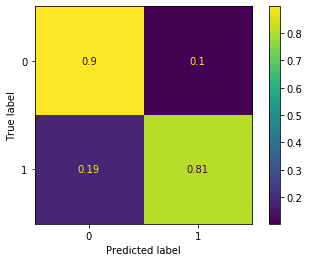

In [25]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred_scores))
plot_confusion_matrix(model, X_test, y_test, normalize='true')

#### Neural Network 

In [26]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

Instructions for updating:
non-resource variables are not supported in the long term
TF version:  2.4.1
Eager execution enabled:  False


In [27]:
def create_nn_sofmax(input_dim):
    model = Sequential()
    model.add(Input(shape=input_dim))
#     model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))    
    return model

In [28]:
y_train_b = to_categorical(y_train)
y_test_b = to_categorical(y_test)

In [29]:
# class_names = ['Bad', 'Good']

nn = create_nn_sofmax(X_train.shape[1])

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.summary()

nn.fit(X_train, y_train_b, batch_size=128, epochs=50, verbose=1, shuffle=False, validation_split=0.1)   


score = nn.evaluate(X_train, y_train_b, verbose=0)
print('Train accuracy:', score[1])

score = nn.evaluate(X_test, y_test_b, verbose=0)
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________
Train on 217 samples, validate on 25 samples
Epoch 1/50
217/217 [==============================] - 0s 307us/sample - loss: 0.6620 - acc: 0.6175 - val_loss: 0.6459 - val_acc: 0.6400
Epoch 2/50
217/217 [==============================] - 0s 13us/sample - loss: 0.6536 - acc: 0.6359 - val_loss: 0.6359 - val_acc: 0.6400
Epoch 3/50
217/217 [==============================] - 0s 13us/sample - l

/home/milton/anaconda3/envs/alibi/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 44/50
217/217 [==============================] - 0s 14us/sample - loss: 0.4505 - acc: 0.7926 - val_loss: 0.4036 - val_acc: 0.8400
Epoch 45/50
217/217 [==============================] - 0s 14us/sample - loss: 0.4483 - acc: 0.7926 - val_loss: 0.4020 - val_acc: 0.8400
Epoch 46/50
217/217 [==============================] - 0s 13us/sample - loss: 0.4462 - acc: 0.7926 - val_loss: 0.4006 - val_acc: 0.8400
Epoch 47/50
217/217 [==============================] - 0s 17us/sample - loss: 0.4441 - acc: 0.7880 - val_loss: 0.3992 - val_acc: 0.8400
Epoch 48/50
217/217 [==============================] - 0s 13us/sample - loss: 0.4421 - acc: 0.7880 - val_loss: 0.3978 - val_acc: 0.8800
Epoch 49/50
217/217 [==============================] - 0s 13us/sample - loss: 0.4401 - acc: 0.7880 - val_loss: 0.3965 - val_acc: 0.9200
Epoch 50/50
217/217 [==============================] - 0s 14us/sample - loss: 0.4382 - acc: 0.7926 - val_loss: 0.3952 - val_acc: 0.9200
Train accuracy: 0.80991733
Test accuracy: 0.9180

# XAI

In [30]:
class_names = ['Normal', 'Disease']

In [121]:
idx = 1
X_idx = X_test.iloc[[idx]]

## Feature Importance e Permutaion Importance - ELI5
Fornece a importância das features (feature importances) para qualquer modelo black-box. Acessa as informações de diferentes modelos, e garante o funcionamento da funcionalidade utilizando o método permutation importance para realizar modificações e verificar como muda o resultado. Disponível em https://github.com/TeamHG-Memex/eli5.

In [103]:
import eli5
from eli5.sklearn import PermutationImportance

In [70]:
eli5.show_weights(model, feature_names=X_train.columns.tolist())

In [105]:
## Opção com PermutationImportance

# perm = PermutationImportance(model,n_iter=5).fit(X_train, y_train)
# eli5.show_weights(perm, feature_names=X_train.columns.tolist())

## LIME (Local Interpretable Model-Agnostic Explanation)
Sorrogate model que atual localmente ao redor dos vizinhos de uma instância. O modelo linear é capaz de capturar o comportamento naquele local.

In [46]:
import lime
import lime.lime_tabular

In [47]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, training_labels=y_train, class_names=class_names,
                                                   feature_names=X_train.columns, kernel_width=3, discretize_continuous=True, verbose=False)

In [48]:
exp = explainer.explain_instance(X_idx.values[0], model.predict_proba, num_features=15)
exp.show_in_notebook()

## Anchor
Desenvolvido pelos mesmos criados do LIME, o algoritmo é uma extensão deste em que é utilizada Árvores de Decisão e são geradas "âncoras" das predições, que representam as características principais para alcançar determinada saída. Disponível em https://github.com/marcotcr/anchor.

In [49]:
from anchor import utils
from anchor import anchor_tabular

In [51]:
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    X_train.columns.tolist(),
    X_train.values)

In [66]:
print('Prediction: ', explainer.class_names[model.predict(X_idx)[0]])
exp = explainer.explain_instance(X_idx.iloc[0].values, model.predict, threshold=0.90)

Prediction:  Disease


In [67]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: ca > 0.00 AND cp_4 > 0.00 AND exang > 0.00
Precision: 0.93
Coverage: 0.16


In [68]:
exp.show_in_notebook()

## SHAP (SHapley Additive exPlanations)
O objetivo do algoritmo SHAP é explicar a predição de uma instância computando as contribuições das features. SHAP tem forte fundamentação na teoria do jogos com a técnica Shapley values. Fornece interpretação local e global. O autor disponibilizou a implementação em https://github.com/slundberg/shap.

In [43]:
import shap
shap.initjs()

### Global

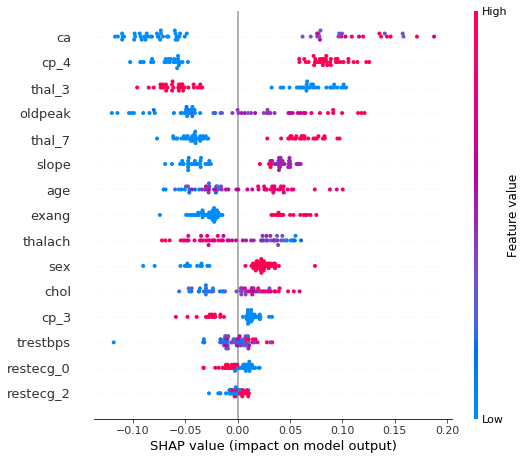

In [44]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=15)

### Local

In [122]:
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_idx)

## PDP (Partial Dependence Plot)
Técnica de visualização para explicações que mostra o efeito marginal de uma ou duas variáveis nas predições dos modelos de ML. O método serve para mostrar as relações entre estes. Experimentos com biblioteca PDPbox (https://github.com/SauceCat/PDPbox).

In [72]:
from pdpbox import pdp, get_dataset, info_plots

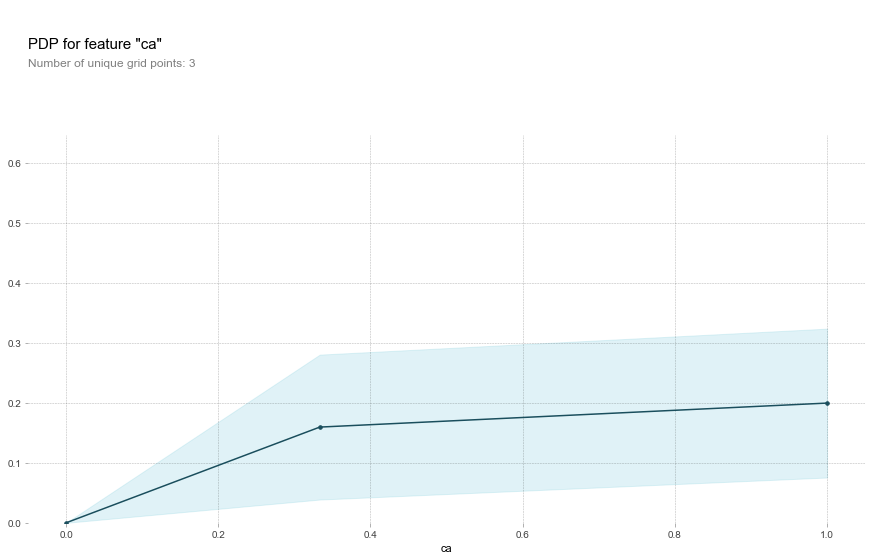

In [73]:
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='ca')

pdp.pdp_plot(pdp_goals, 'ca')
plt.show()

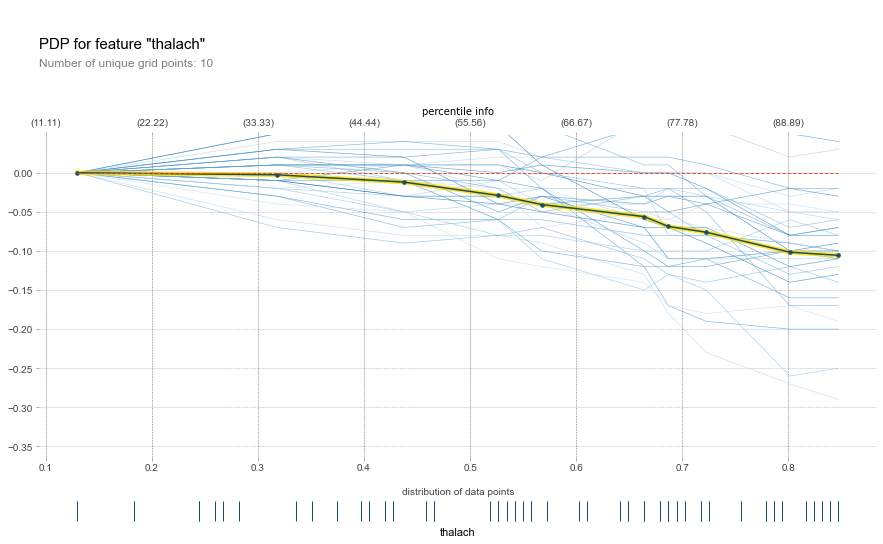

In [401]:
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='thalach')

fig, axes = pdp.pdp_plot(
    pdp_goals, 'thalach', frac_to_plot=0.5, plot_lines=True, x_quantile=False, show_percentile=True, plot_pts_dist=True
)

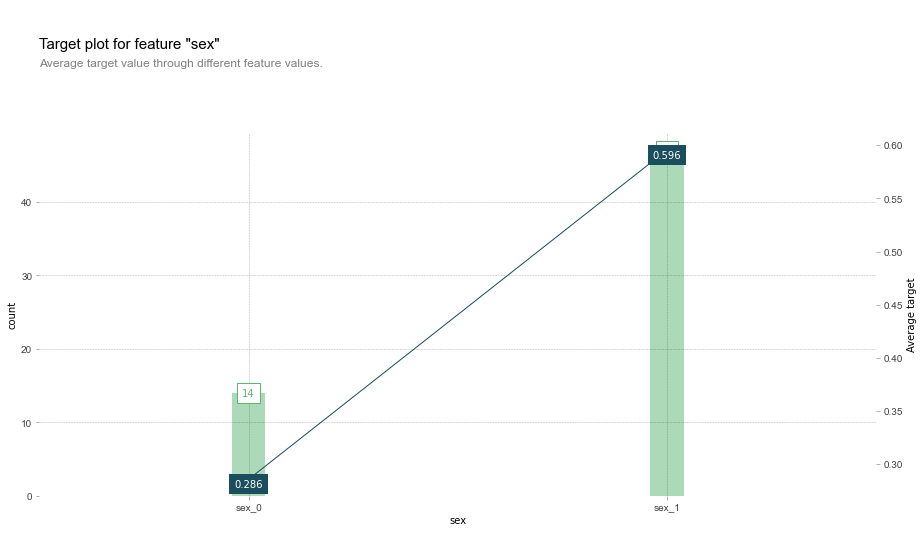

In [368]:
fig, axes, summary_df = info_plots.target_plot(
    df=pd.concat([X_test, y_test.reset_index(drop=True)], axis=1), feature='sex', feature_name='sex', target='target'
)

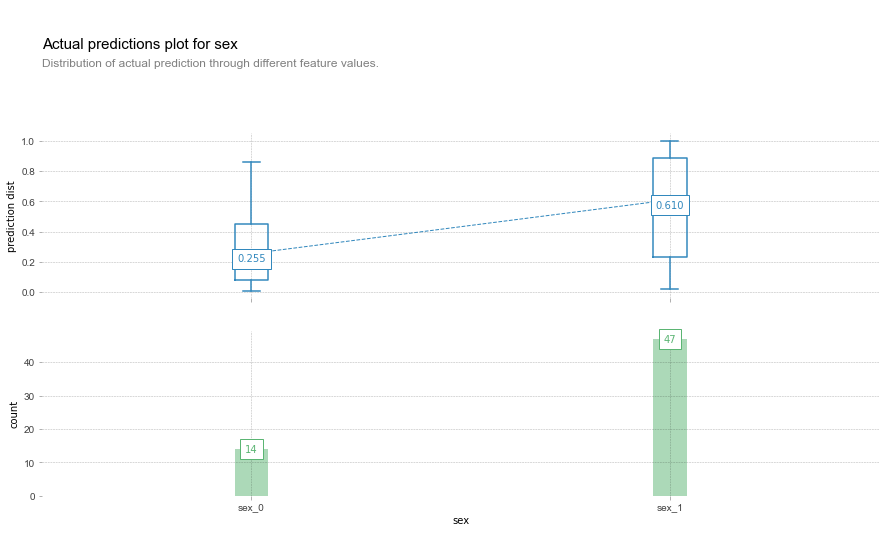

In [402]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model, X=X_test, feature='sex', feature_name='sex', predict_kwds={}
)

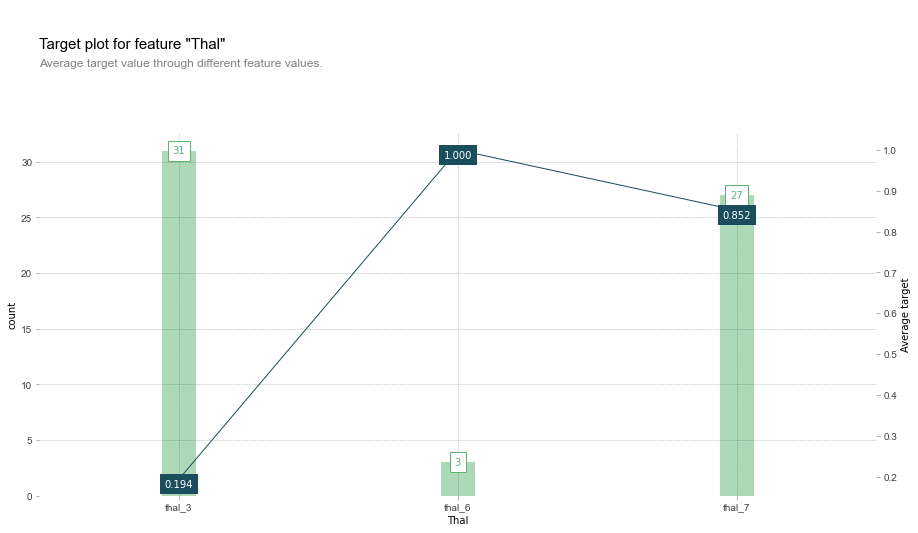

In [403]:
fig, axes, summary_df = info_plots.target_plot(
    df=pd.concat([X_test, y_test.reset_index(drop=True)], axis=1), feature=['thal_3', 'thal_6', 'thal_7'], feature_name='Thal', target='target'
)

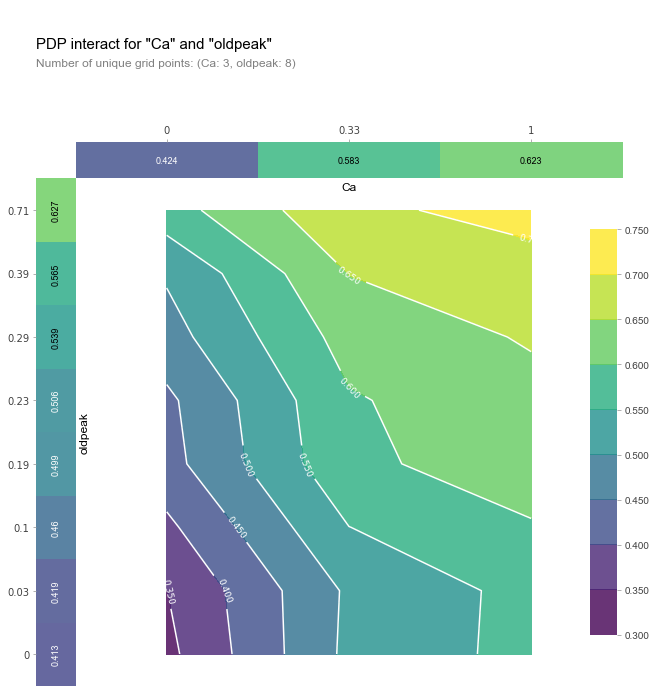

In [397]:
inter1 = pdp.pdp_interact(
    model=model, dataset=X_test, model_features=X_test.columns, features=['ca', 'oldpeak']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['ca', 'oldpeak'], plot_type='contour', x_quantile=True, plot_pdp=True
)

## ALE Plot ou Accumulated Local Effects Plot
Descreve como as features influenciam as predições dos modelos na média. É similar e inspirado no PDP, porém utiliza algumas propriedades matemáticas diferentes como a utilização de média e não assumir que os atributos são independentes e sem correlação, como ocorre no PDP. Os experimentos foram realizados com a biblioteca Alibi (https://github.com/SeldonIO/alibi).

In [77]:
from alibi.explainers import ALE, plot_ale

In [78]:
ale = ALE(model.predict_proba, feature_names=X_test.columns.tolist(), target_names=class_names)

In [79]:
exp = ale.explain(X_test.values)

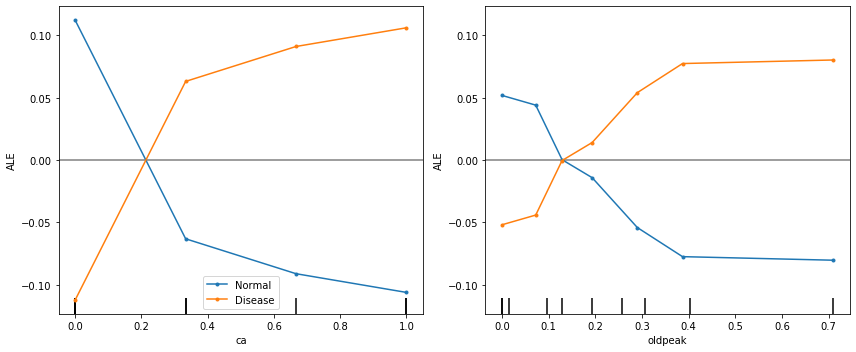

In [86]:
plot_ale(exp, features=['ca', 'oldpeak'], fig_kw={'figwidth': 12, 'figheight': 5}, sharey='all')
plt.show()

## Counterfactual
O algoritmo tem o objetivo de identificar o conjunto mínimo de modificações nas características de uma instância para produzir uma predição predefida, neste caso, para obter a outra classe. Nesse experimento foi utilizado uma variação do algoritmo orginal Counterfactual, chamado CounterfacualProto. Este algoritmo combina o original com Protótipos, alcançando o resultado com maior velocidade, além de implementar uma versão que funciona bem com variáveis categóricas. Foi utilizado a implementação da biblioteca Alibi (https://github.com/SeldonIO/alibi).

In [32]:
from alibi.explainers import CounterFactual, CounterFactualProto
from alibi.utils.mapping import ohe_to_ord_shape, ohe_to_ord, ord_to_ohe

In [33]:
rng = feature_range
rng_shape = (1,) + (13,)
feature_range_numeric = ((np.ones(rng_shape) * rng[0]).astype(np.float32), (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [34]:
cat_cols_dict = {0: 3, 3: 3, 6:4}

In [35]:
cf = CounterFactualProto(nn,
                         X_idx.shape,
                         beta=.01,
                         cat_vars=cat_cols_dict,
                         ohe=True,
                         max_iterations=1000,
                         feature_range=feature_range_numeric,
                         c_init=1.,
                         c_steps=5
                        )

cf.fit(X_train.values)
explanation = cf.explain(X_idx.values)

In [36]:
pred_class_original = explanation['orig_class']
proba_original = explanation['orig_proba'][0][pred_class_original]

print(f'Original prediction: {pred_class_original} with probability {proba_original}') 

pred_class_cf = explanation.cf['class']
proba_cf = explanation.cf['proba'][0][pred_class_cf]

print(f'Counterfactual prediction: {pred_class_cf} with probability {proba_cf}')

Original prediction: 1 with probability 0.6100563406944275
Counterfactual prediction: 0 with probability 0.5155072212219238


In [37]:
X_cf = explanation['cf']['X']

In [38]:
def highlight_ce(s, col, ncols):
        if (type(s[col]) != str):
            if (s[col] > 0):
                return(['background-color: yellow']*ncols)    
            if (s[col] < 0):
                return(['background-color: red']*ncols)    
        return(['background-color: white']*ncols)

In [39]:
def create_dataframe_instances(X_idx, X_new, name):
    idx = X_idx.index[0]
    Xpn = X_new #explanation['cf']['X']

    classes = [ class_names[np.argmax(nn.predict_proba(X_idx))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]


    delta_re = Xpn - X_idx.values
    delta_re = np.around(delta_re.astype(np.double), 2)
    delta_re[np.absolute(delta_re) < 1e-4] = 0

    X_idx_df = X_idx.iloc[0]
    Xpn_df = pd.Series(Xpn[0], index=X_train.columns)
    delta_re_df = pd.Series(delta_re[0], index=X_train.columns)

    X_idx_df.name = 'X'
    Xpn_df.name = name
    delta_re_df.name = name + ' - X'
    
    
    dfre = pd.concat([X_idx_df, Xpn_df, delta_re_df], axis=1)
    dfre.loc['Class', :] = classes
    
    return dfre

In [40]:
def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
        if (s[col] < 0):
            return(['background-color: red']*ncols)    
    return(['background-color: white']*ncols)


In [41]:
df_result = create_dataframe_instances(X_idx, X_cf, 'CF')

In [42]:
df_result.style.apply(highlight_ce, col='CF - X', ncols=3, axis=1)